In [1]:
from UTILITY_quickstart import *

In [2]:
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch.yml")
importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch_baseline.yml")
#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_twoIslandStudy.yml")

In [3]:
csrTF = True
evalElement = "PENT"
#evalElement = "BEGPDC"


inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
bunchCount = importedDefaultSettings["bunchCount"]
tao = initializeTao(
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e5,
    scratchPath = "/tmp",
    randomizeFileNames = True
)


#tao.cmd("set ele * space_charge_method = slice")
#tao.cmd("set ele * space_charge_method = fft_3d")


# activeSettings = importedDefaultSettings | {
#     # "S1EL_xOffset" : 0.00,  
#     # "S1EL_yOffset" : 0.0,  
#     # #"S2EL_xOffset" : 0.002,  
#     # "S2EL_yOffset" : 0.0,  
#     # "S2ER_xOffset" : 0.0,  
#     # "S2ER_yOffset" : 0.0,  
#     # "S1ER_xOffset" : 0.0,  
#     # "S1ER_yOffset" : 0.0,

#     # #"XC1FFkG" : 0.2321150061,


#     # #Sextupole compensated, CSR off
#     # "S2EL_xOffset" : 0.002, 
#     # "XC1FFkG" : 0.19,

# }
# setLattice(tao, **activeSettings)



# ffOverride = finalFocusSolver(tao, 
#              ele = "PENT",
#              s_offset = 0,
#              targetBetaX = 0.1,
#              targetAlphaX = 0.0,
#              targetBetaY = 0.1,
#              targetAlphaY = 0,
#              verbose = True
#              );

# importedDefaultSettings = importedDefaultSettings | ffOverride

setLattice(tao, **importedDefaultSettings)

#Rescale charge
# newCharge = 1e-12
# trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
# P = getBeamAtElement(tao, "L0AFEND")
# print(f"""\n\n\nAs imported charge: {P.charge}""")
# P.charge = newCharge
# makeBeamActiveBeamFile(P)
# tao.cmd('reinit beam')

#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))
print(f"""New charge: {PInit.charge}""")

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 100000.0
Beam created, written to /tmp/beams/activeBeamFile_18291875648587537267.h5, and reinit to tao
Loaded /tmp/beams/activeBeamFile_18291875648587537267.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting
New charge: 1.6007982080000007e-09


In [4]:
trackBeam(tao, 
          **importedDefaultSettings,
          verbose = True
         )

Loaded /tmp/beams/activeBeamFile_18291875648587537267.h5
Set track_start = L0AFEND, track_end = end
Tracking!
trackBeam() exiting


In [5]:
P = getBeamAtElement(tao, evalElement)


if bunchCount == 1:
    PDrive = P.copy()
elif bunchCount == 2:
    PDrive, PWitness = getDriverAndWitness(P)


savedData = getBeamSpecs(P, targetTwiss = evalElement)

savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

In [6]:
(getBeamAtElement(tao, "PENT")).write("beams/optimizerRunningBestBeam_PENT.h5")
savedData

{'PDrive_median_x': 1.196988969428014e-05,
 'PDrive_median_y': 1.9741604367691227e-05,
 'PDrive_median_xp': -3.984331034314294e-05,
 'PDrive_median_yp': -0.00012377804144313945,
 'PDrive_median_energy': 9898643926.844326,
 'PDrive_sigmaSI90_x': 2.3694051496244034e-05,
 'PDrive_sigmaSI90_y': 2.012768699828369e-05,
 'PDrive_sigmaSI90_z': 2.0374274704795686e-05,
 'PDrive_sigmaSI90_xp': 7.323685716940502e-05,
 'PDrive_sigmaSI90_yp': 5.8106120176011336e-05,
 'PDrive_sigmaSI90_energy': 78645413.22302446,
 'PDrive_emitSI90_x': 2.8417966633828895e-05,
 'PDrive_emitSI90_y': 1.5665627951610574e-05,
 'PDrive_norm_emit_x': 7.3523437430611285e-06,
 'PDrive_norm_emit_y': 4.668778011198677e-06,
 'PDrive_zCentroid': 991.3317395447775,
 'PDrive_charge_nC': 1.2003031040000005,
 'PDrive_BMAG_x': 1.5188479340536043,
 'PDrive_BMAG_y': 1.1262028618714268,
 'PDrive_sliced_BMAG_x': [3.8455830586383546,
  4.862522427651727,
  3.5021518581439857,
  2.164672746623506,
  2.219500299319672],
 'PDrive_sliced_BMAG_y

In [7]:

if bunchCount == 2:
    print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")
    
    print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2) :.3g} um""")
    print(f"""Angular misalignment: \t{1e3*np.sqrt((savedData["PDrive_median_xp"] - savedData["PWitness_median_xp"])**2 + (savedData["PDrive_median_yp"] - savedData["PWitness_median_yp"])**2) :.3g} mrad""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
if bunchCount == 2:
    print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g} × {1e6 * savedData["PDrive_sigmaSI90_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g} × {1e6 * savedData["PWitness_sigmaSI90_z"] :.3g} um""")



print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
if bunchCount == 2: 
    print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g} × {1e6 * PDrive["sigma_y"] :.3g} × {1e6 * PDrive["sigma_z"] :.3g} um""")
if bunchCount == 2:
    print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g} × {1e6 * PWitness["sigma_y"] :.3g} × {1e6 * PWitness["sigma_z"] :.3g} um""")

Bunch spacing: 		202 um
Transverse offset: 	26 um
Angular misalignment: 	0.16 mrad

Emittances and sigmas - implied by 90% charge
Driver emittance: 	28.4 × 15.7 um-rad
Witness emittance: 	17.5 × 10.7 um-rad
Driver sigma_x,y,z: 	23.7 × 20.1 × 20.4 um
Witness sigma_x,y,z: 	18.9 × 20.3 × 9.04 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	36.4 × 18 um-rad
Witness emittance: 	20.4 × 16.5 um-rad
Driver sigma_x,y,z: 	24.9 × 20.3 × 30.6 um
Witness sigma_x,y,z: 	20.3 × 24 × 11.1 um


Drive:


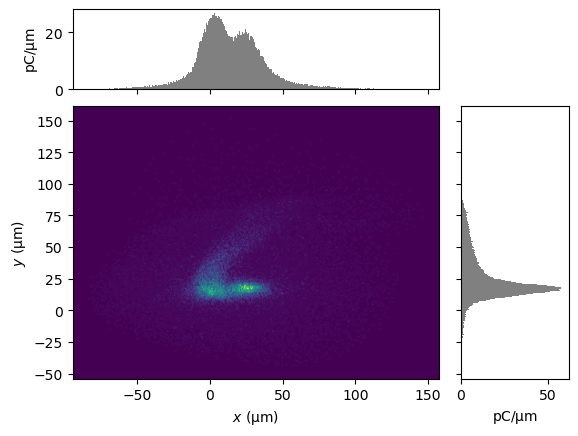

Witness:


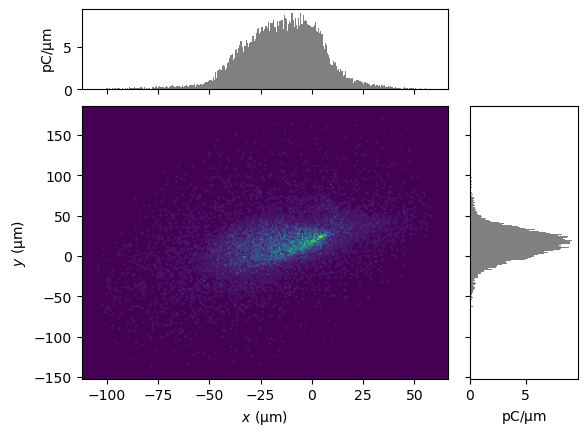

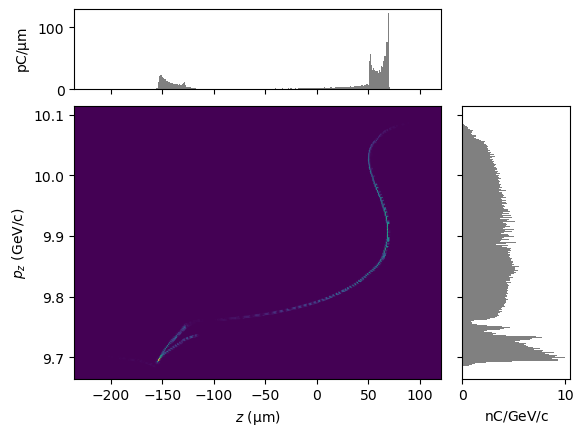

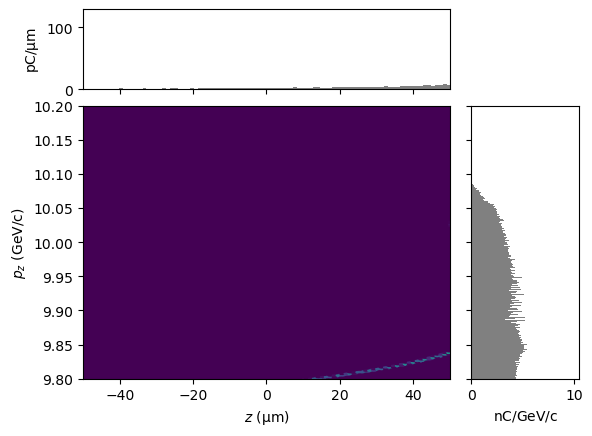

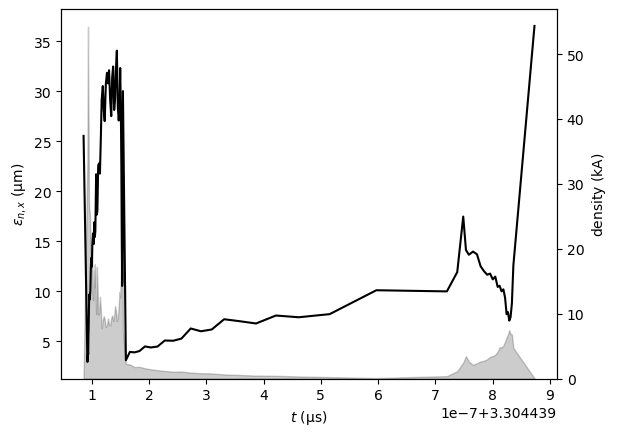

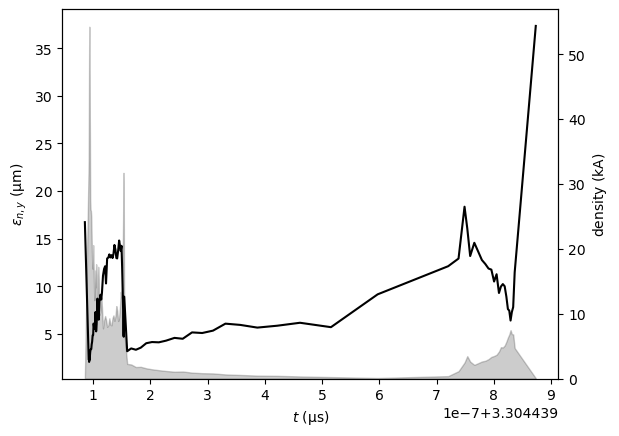

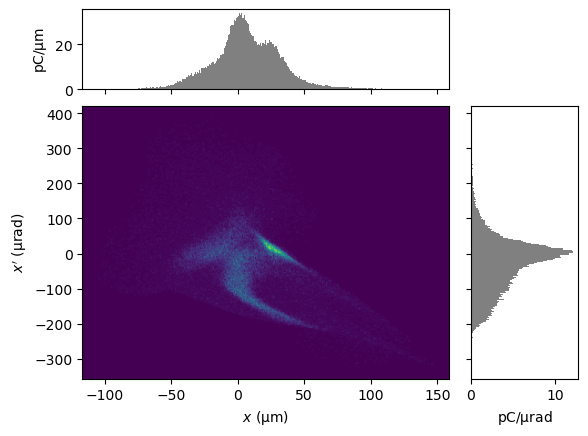

<Figure size 640x480 with 0 Axes>

In [8]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
if bunchCount == 2:
    print("Witness:")
    display(plotMod(PWitness, 'x', 'y',  bins=300))
    
display(plotMod(P, 'z', 'pz', bins=300))


display(plotMod(P, 'z', 'pz', bins=300, xlim = (-50e-6, 50e-6), ylim = (9.8e9, 10.2e9)))


display(slicePlotMod(P, 'norm_emit_x', slice_key = "t", n_slice=100))
display(slicePlotMod(P, 'norm_emit_y', slice_key = "t", n_slice=100))

display(plotMod(P, 'x', 'xp', bins=300))
plt.clf()

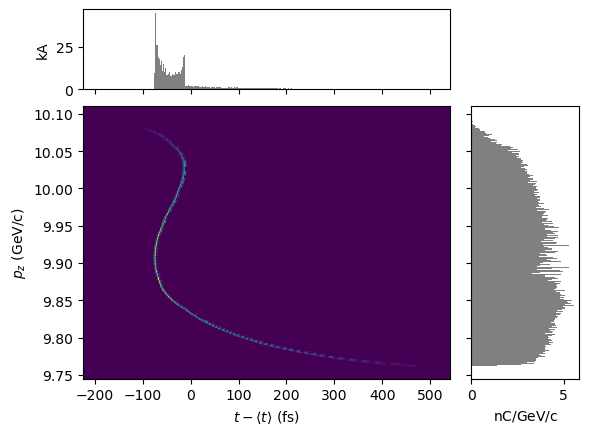

In [9]:
display(plotMod(PDrive, 'delta_t', 'pz', bins=300))

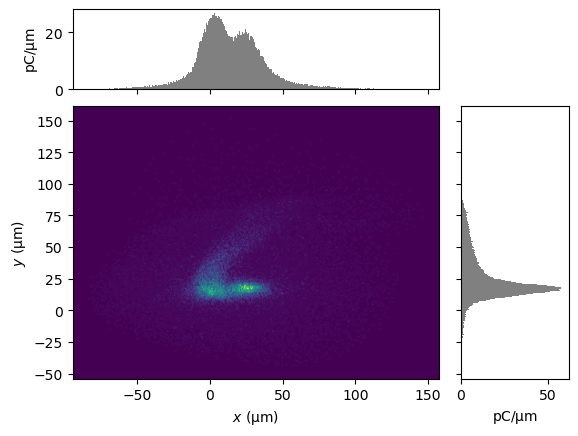

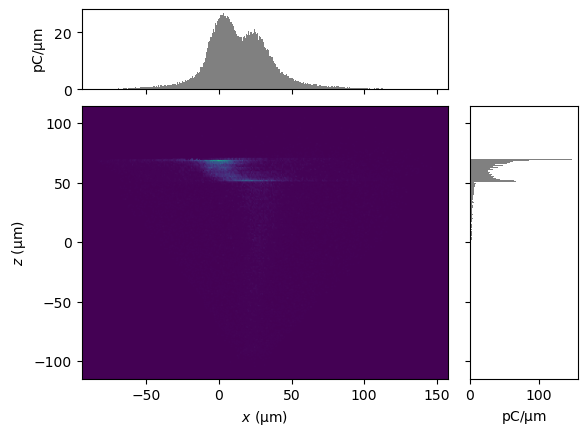

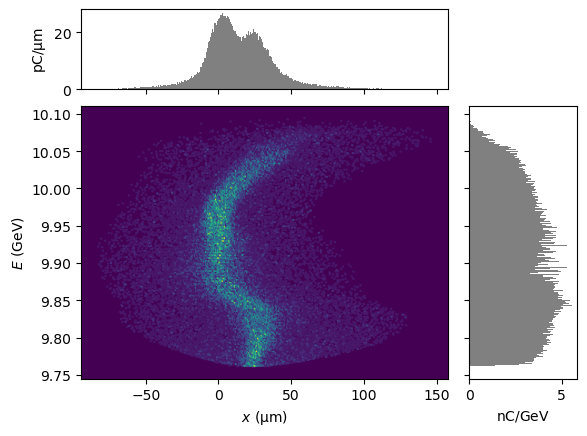

In [10]:
P = getBeamAtElement(tao, "YCWIGE")
display(plotMod(PDrive, 'x', 'y',  bins=300))
display(plotMod(PDrive, 'x', 'z',  bins=300))
display(plotMod(PDrive, 'x', 'energy',  bins=300))

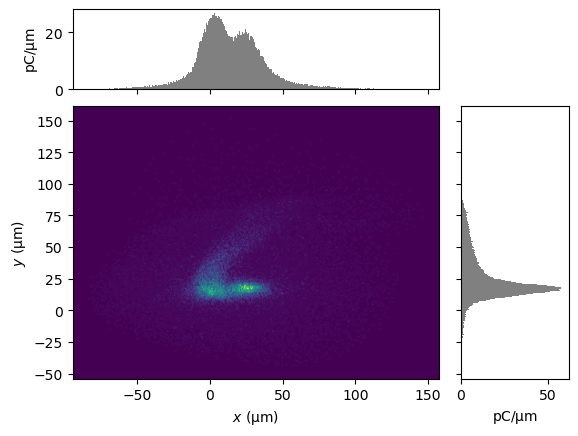

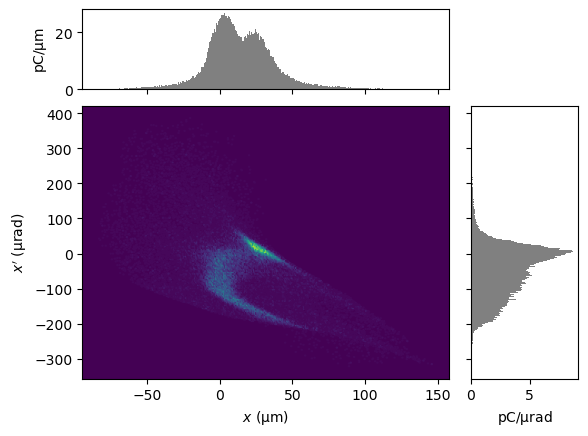

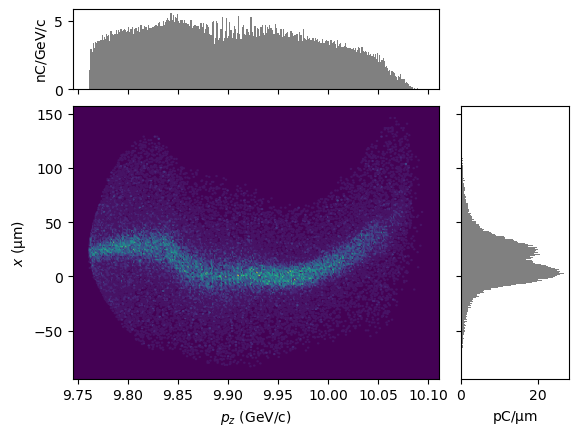

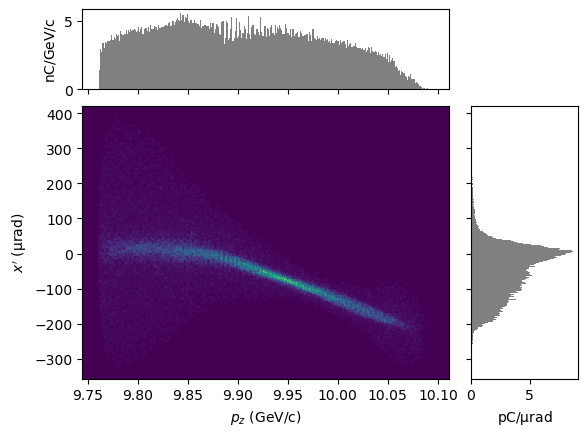

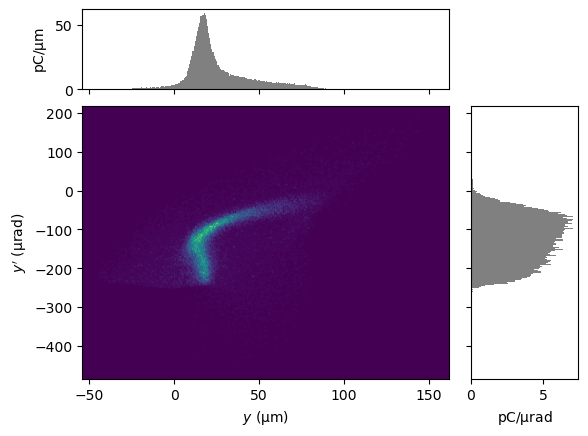

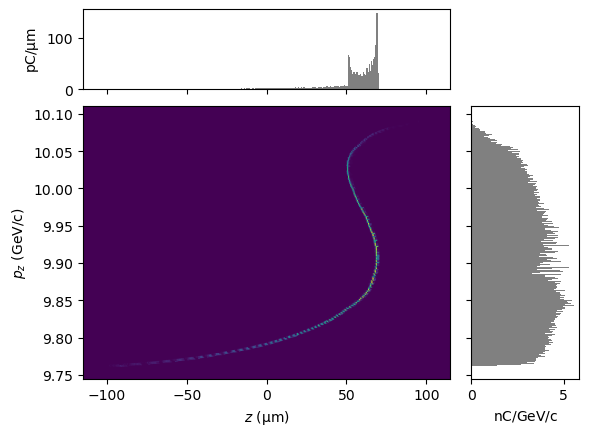

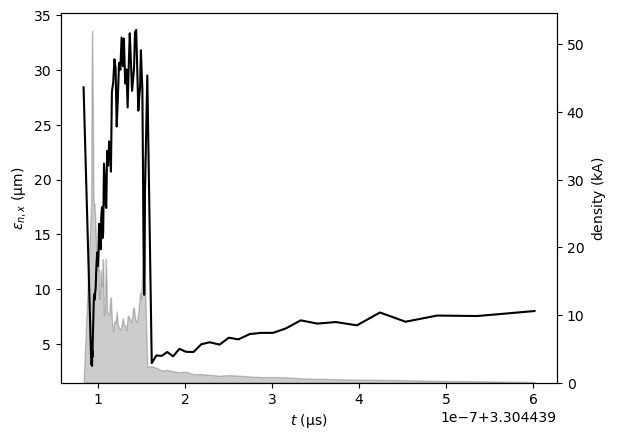

In [11]:
display(plotMod(PDrive, 'x', 'y',  bins=300))

display(plotMod(PDrive, 'x', 'xp', bins=300))
display(plotMod(PDrive, 'pz', 'x', bins=300))
display(plotMod(PDrive, 'pz', 'xp', bins=300))

display(plotMod(PDrive, 'y', 'yp', bins=300))
display(plotMod(PDrive, 'z', 'pz', bins=300))
display(slicePlotMod(PDrive, 'norm_emit_x',n_slice=100))

## Further study at other elements

In [12]:
?calcBMAG

Signature: calcBMAG(b0, a0, b, a)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [13]:
#def addBMAGToDict(dict, targetBeta, targetAlpha)

In [14]:
P = getBeamAtElement(tao, "PR10571")
#PDrive, PWitness = getDriverAndWitness(P)


#PR10571 lucretia live model lattice 2024-10-16
targetBetaX = 5.7
targetBetaY = 2.6
targetAlphaX = -2.1
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System BMAG:  1.024449584474377, 1.0031450749012396

System emit:  2.875222108566034e-06, 3.046640487748573e-06


In [15]:
P = getBeamAtElement(tao, "BEGBC20")
#PDrive, PWitness = getDriverAndWitness(P)


#BEGBC20 lucretia live model lattice 2024-10-16
targetBetaX = 11.5
targetBetaY = 27.3
targetAlphaX = 0.7
targetAlphaY = 1.2

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")


System BMAG:  1.0595752208440967, 1.6724503957896961

System emit:  9.307867648567985e-06, 2.6974171950070312e-06


In [16]:
P = getBeamAtElement(tao, "MFFF")
#PDrive, PWitness = getDriverAndWitness(P)
PDrive = P


#MFFF lucretia live model lattice 2024-10-16
targetBetaX = 11.6
targetBetaY = 25.2
targetAlphaX = -0.64
targetAlphaY = -1.6

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 12.571759958342374, 27.05742689266055
Drive alpha x / y: -1.1073743476190476, -2.4975901566746384

System BMAG:  1.0822198262501244, 1.2855991417121275

System emit:  1.9831521127055283e-05, 1.3400213834599472e-05


In [17]:
P = getBeamAtElement(tao, "PENT")
#PDrive, PWitness = getDriverAndWitness(P)

#PENT lucretia live model lattice 2024-10-16
targetBetaX = 0.5
targetBetaY = 0.5
targetAlphaX = 0.0
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System beta x / y: {PTwiss["beta_x"]}, {PTwiss["beta_y"]}""")
print(f"""System alpha x / y: {PTwiss["alpha_x"]}, {PTwiss["alpha_y"]}""")

#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

#print(f"""Witness beta x / y: {PWitnessTwiss["beta_x"]}, {PWitnessTwiss["beta_y"]}""")
#print(f"""Witness alpha x / y: {PWitnessTwiss["alpha_x"]}, {PWitnessTwiss["alpha_y"]}""")

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System beta x / y: 0.45000115319651496, 0.5400362345098848
System alpha x / y: -0.005500397716640106, -0.6466627872224228
System BMAG:  1.0055720929993788, 1.1965536447098453

System emit:  1.703071597322184e-05, 7.706916906586761e-06


PR10571


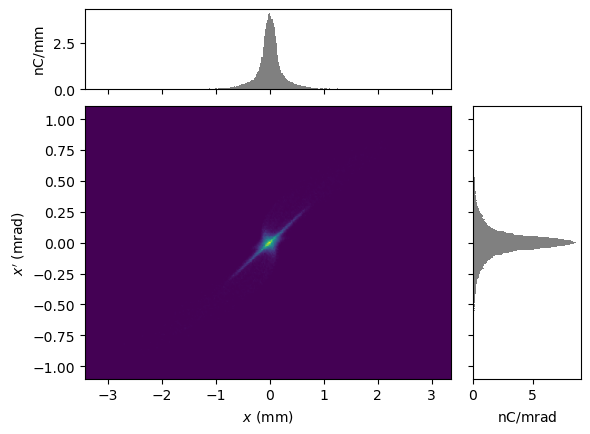

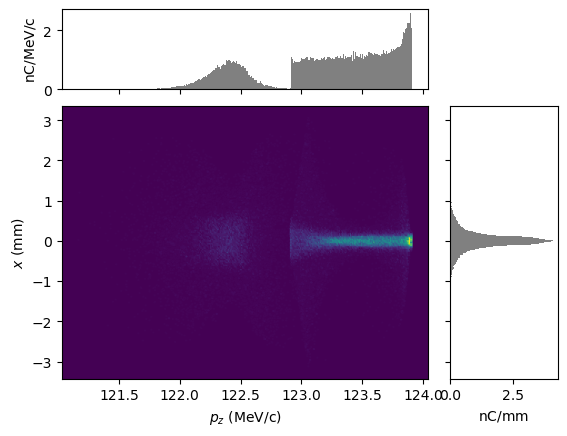

BEGBC20


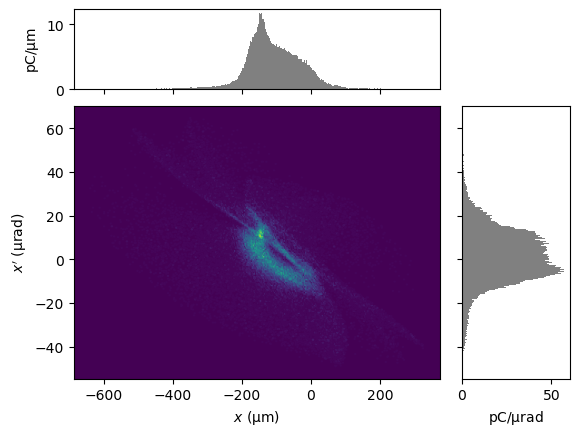

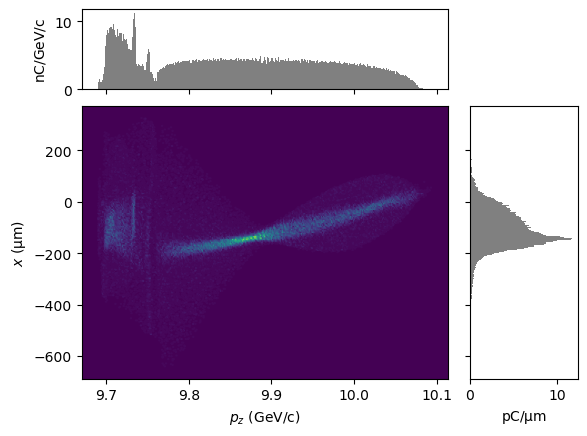

MFFF


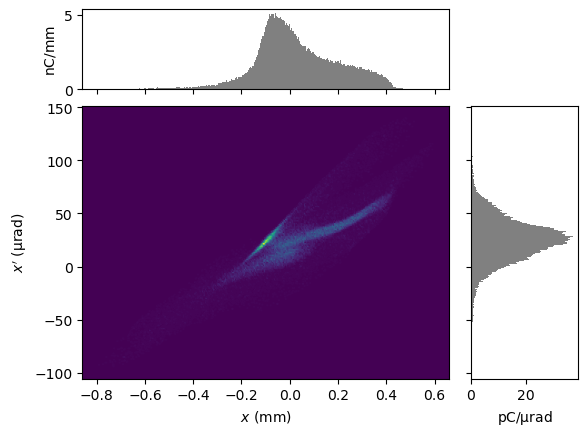

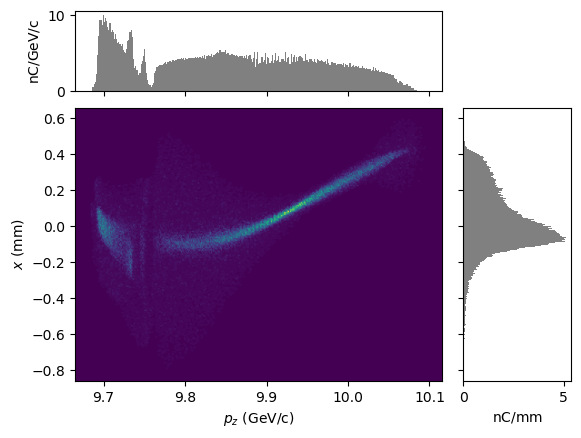

PENT


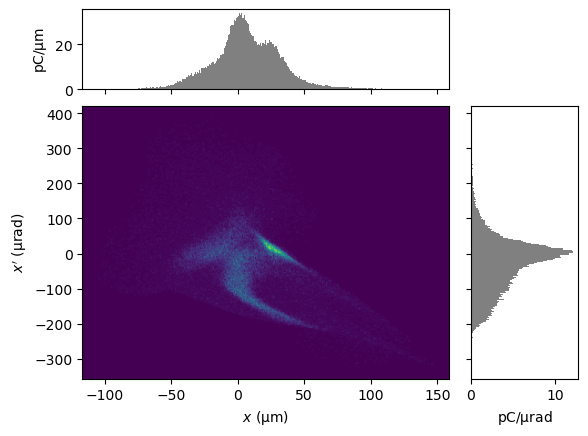

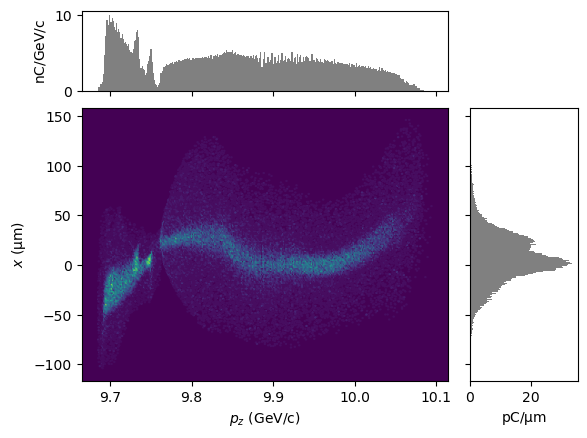

In [18]:
for activeElement in ["PR10571", "BEGBC20", "MFFF", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    #PDrive, PWitness = getDriverAndWitness(P)
    
    display(plotMod(P, 'x', 'xp',  bins=300))
    display(plotMod(P, 'pz', 'x',  bins=300))

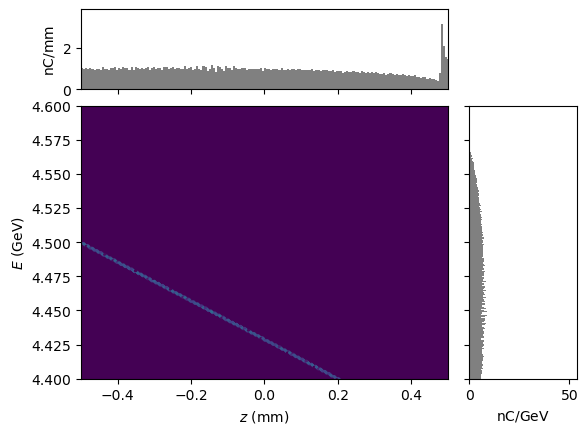

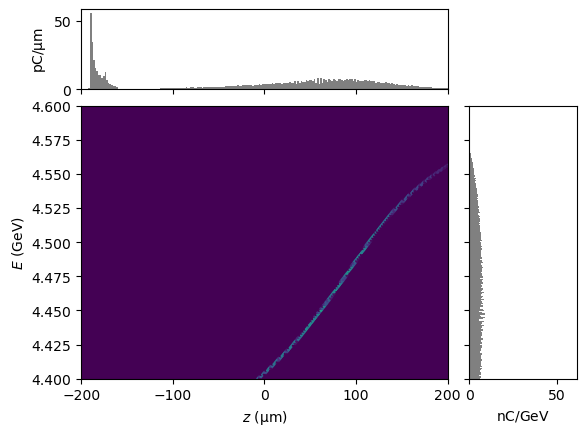

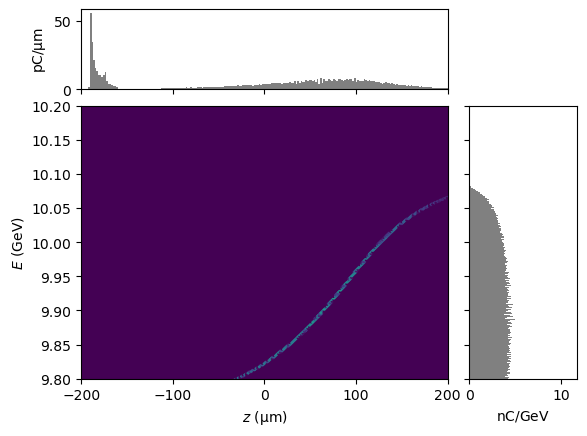

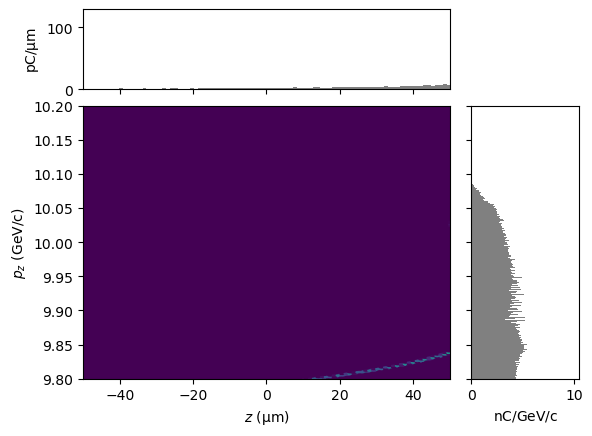

In [19]:
P = getBeamAtElement(tao, "BEGBC14_1")
display(plotMod(P, 'z', 'energy',  bins=300, xlim = (-500e-6, 500e-6), ylim = (4.4e9, 4.6e9)))

P = getBeamAtElement(tao, "ENDBC14_2")
display(plotMod(P, 'z', 'energy',  bins=300, xlim = (-200e-6, 200e-6), ylim = (4.4e9, 4.6e9)))

P = getBeamAtElement(tao, "BEGBC20")
display(plotMod(P, 'z', 'energy',  bins=300, xlim = (-200e-6, 200e-6), ylim = (9.8e9, 10.2e9)))

P = getBeamAtElement(tao, "PENT")
display(plotMod(P, 'z', 'pz', bins=300, xlim = (-50e-6, 50e-6), ylim = (9.8e9, 10.2e9)))

# Check beam specs at treaty points

In [20]:
print("DL10")
getMatrix(tao,"LH10END", "BEGL1F",print=True);
print("BC11")
getMatrix(tao,"BEGBC11_1", "BEGL2F",print=True);
print("BC14")
getMatrix(tao,"ENDL2F", "BEGL3F_1",print=True);
print("BC20")
getMatrix(tao,"BEGBC20", "MFFF",print=True);

DL10


1.463641,-1.668376,0.000000,0.000000,0.000000,-0.000000
-0.068101,0.760854,-0.000000,0.000000,0.000000,-0.000000
0.000000,0.000000,-1.423575,-3.962329,0.000000,-0.000000
0.000000,0.000000,-1.109009,-3.789237,0.000000,-0.000000
0.000000,-0.000000,0.000000,0.000000,1.000000,-0.006137
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC11


5.503387,-24.775546,0.000000,0.000000,0.000000,-0.000000
-0.203411,1.097438,-0.000000,-0.000000,0.000000,0.000000
-0.000000,0.000000,0.353439,2.781447,0.000000,0.000000
0.000000,-0.000000,-0.601774,-1.906419,0.000000,-0.000000
-0.000000,0.000000,-0.000000,-0.000000,1.000000,0.046019
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC14


0.017604,17.783586,0.000000,0.000000,-0.000000,0.000007
-0.055048,1.195609,-0.000000,0.000000,-0.000000,0.000001
0.000000,-0.000000,-1.113837,35.842064,0.000000,-0.000000
0.000000,0.000000,-0.004217,-0.762114,-0.000000,0.000000
-0.000000,-0.000016,0.000000,0.000000,1.000000,0.036014
0.000000,0.000000,0.000000,0.000000,-0.000000,1.000000


BC20


-1.556747,-5.270267,0.031358,0.090391,0.000000,0.033296
-0.247530,-1.480986,0.008231,-0.007200,0.000000,0.002801
0.055050,0.157681,-0.995170,-4.292784,0.000000,0.004510
0.008226,0.005947,-0.056959,-1.251527,0.000000,-0.000884
-0.003796,-0.034383,-0.000951,-0.009933,1.000000,-0.009123
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [21]:
P = getBeamAtElement(tao, "L0BFEND")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""SI90 emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")
print(f"""norm_emit: {1e6 * P["norm_emit_x"]}, {1e6 * P["norm_emit_y"]} um-rad""")

E: 0.12319402569868013 GeV 
sig_z: 1018.3912069056528 um
sig_E: 0.38381326452841535 %
SI90 emittance: 5.70215589209301, 4.379833532331102 um-rad
norm_emit: 6.668052576085732, 6.782803551554243 um-rad


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:530: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


In [22]:
P = getBeamAtElement(tao, "BEGL2F")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 0.331490629439036 GeV 
sig_z: 412.04741566014917 um
sig_E: 1.285522689869714 %


In [23]:
P = getBeamAtElement(tao, "BEGL3F_1")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 4.424973557523968 GeV 
sig_z: 100.45611607180935 um
sig_E: 1.371598872638845 %


In [24]:
P = getBeamAtElement(tao, "BEGBC20")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")

E: 9.861792278491963 GeV 
sig_z: 100.57810665555152 um
sig_E: 0.9861995272066201 %
emittance: 15.380364162881099, 6.742047461242796 um-rad


In [25]:
P = getBeamAtElement(tao, "PENT")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 9.857078633736714 GeV 
sig_z: 66.00445011277421 um
sig_E: 0.9824347275093313 %


In [26]:
importedDefaultSettings

{'QA10361kG': -2.2481515833,
 'QA10371kG': 2.338890812,
 'QE10425kG': -1.0721888188,
 'QE10441kG': 1.3152401751,
 'QE10511kG': 0.2241208022,
 'QE10525kG': 0.6276060908,
 'Q19851kG': -64.095,
 'Q19871kG': 44.936,
 'B1EkG': 7.533,
 'B2EkG': -10.942,
 'B3EkG': 3.409,
 'Q1EkG': 161.311,
 'Q2EkG': -154.229,
 'Q3EkG': 110.217,
 'Q4EkG': 132.268,
 'Q5EkG': -23.373,
 'Q6EkG': -142.271,
 'symmetricSextupoleStrengths': True,
 'S1ELkG': 2089.4846449653,
 'S2ELkG': -3954.374460403,
 'S3ELkG': -1087.9568814486,
 'S3ERkG': -1019.323,
 'S2ERkG': -2049.489,
 'S1ERkG': 804.871,
 'Q5FFkG': -71.837,
 'Q4FFkG': -81.251,
 'Q3FFkG': 99.225,
 'Q2FFkG': 126.35,
 'Q1FFkG': -235.218,
 'Q0FFkG': 126.353,
 'Q0DkG': -109.694,
 'Q1DkG': 180.862,
 'Q2DkG': -109.694,
 'S1EL_xOffset': 0.0009068268,
 'S1EL_yOffset': 0.0001315754,
 'S2EL_xOffset': -0.000388583,
 'S2EL_yOffset': 0.0001165775,
 'S2ER_xOffset': -0.0001679111,
 'S2ER_yOffset': -0.0014881668,
 'S1ER_xOffset': 0.0013323302,
 'S1ER_yOffset': -0.0011182646,
 'X

In [ ]:
for activeElement in ["L0AFEND", "BEGL2F", "BEGBC14_1", "ENDBC14_2", "BEGBC20", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    display(plotMod(P, 'delta_z', 'energy',  bins=300))

In [28]:
# for activePhase in np.arange(-40, -25, 1):
#     print(activePhase)
#     setLinacPhase(tao, "L2", activePhase)
#     setLinacGradientAuto(tao, "L2", 4.5e9 - 0.335e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     activeElement = "BEGBC20"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.5e-3, 0.5e-3), ylim = (9.5e9, 10.5e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.2e-3, 0.2e-3), ylim = (9.6e9, 10.2e9) ) )
    

In [29]:
# for activePhase in np.arange(-39.0, -33.0, 0.5):
#     print(activePhase)
#     setLinacPhase(tao, "L2", activePhase)
#     setLinacGradientAuto(tao, "L2", 4.5e9 - 0.335e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     # activeElement = "BEGBC20"
#     # P = getBeamAtElement(tao, activeElement)
#     # print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     # display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.1e-3, 0.1e-3), ylim = (9.6e9, 10.0e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     #print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     print(f"""{activeElement}: {1e6 * smallestIntervalImpliedSigma(P.t * 3e8, percentage=0.9)}""")
    
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.1e-3, 0.1e-3), ylim = (9.6e9, 10.0e9) ) )

In [30]:
# for activePhase in np.arange(-75, 0, 5):
#     print(activePhase)
#     setLinacPhase(tao, "L3", activePhase)
#     setLinacGradientAuto(tao, "L3", 10e9 - 4.5e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     activeElement = "BEGBC20"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.5e-3, 0.5e-3), ylim = (9.5e9, 10.5e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.2e-3, 0.2e-3), ylim = (9.6e9, 10.2e9) ) )

In [31]:
getMatrix(tao, "BEGBC20", "PENT", print=True);

-0.306310,-2.544217,0.013775,-0.032782,0.000000,0.001915
0.800820,3.383794,-0.019525,-0.023930,0.000000,-0.014491
-0.018554,0.000040,0.058398,3.288740,0.000000,0.004538
-0.004871,0.052275,-0.256893,2.673288,0.000000,0.005926
-0.002817,-0.030151,-0.001350,-0.007877,1.000000,-0.009134
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [32]:
?getMatrix

Signature:
getMatrix(
    tao,
    start,
    end,
    order=1,
    startOffset=0,
    endOffset=0,
    print=False,
)
Docstring: Return zero or first order transport matrix from start to end, with offsets. Optionally print in a human readable format
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function